In [9]:
import torch
from ogb.nodeproppred import PygNodePropPredDataset
from tqdm import trange
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/")
print(dataset.meta_info)
print(dataset.num_node_features)
print()
print(dataset._data)
splits = dataset.get_idx_split()
[f"{k}: {len(splits[k])/dataset.num_nodes*100:.2f}%" for k in splits.keys()]

num tasks                                                                1
num classes                                                             40
eval metric                                                            acc
task type                                        multiclass classification
download_name                                                        arxiv
version                                                                  1
url                      http://snap.stanford.edu/ogb/data/nodeproppred...
add_inverse_edge                                                     False
has_node_attr                                                         True
has_edge_attr                                                        False
split                                                                 time
additional node files                                            node_year
additional edge files                                                 None
is hetero                

['train: 53.70%', 'valid: 17.60%', 'test: 28.70%']

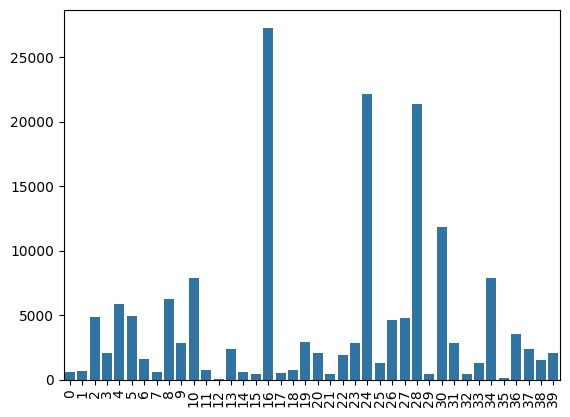

In [10]:
from collections import Counter

c = Counter(dataset.y.flatten().numpy())
sns.barplot(x=c.keys(), y=c.values())
plt.xticks(rotation=90)
plt.show()

In [11]:
import torch.nn as nn
from torch.nn import functional as F


class NN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        nh = 64
        self.l1 = nn.Linear(dataset.num_node_features, nh)
        self.l2 = nn.Linear(nh, nh)
        self.l3 = nn.Linear(nh, dataset.num_classes)

    def forward(self, data):
        x = data.x.float()

        x = self.l1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.l2(x)
        x = F.dropout(x, training=self.training)
        x = self.l3(x)
        return F.log_softmax(x, dim=1)


device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NN().to(device)
data = dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

results = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
tr = trange(400)
for i in tr:
    model.train()
    optimizer.zero_grad()
    out = model(dataset)
    loss = F.nll_loss(out[splits["train"]], dataset.y[splits["train"]].flatten())
    correct = (
        out.argmax(-1)[splits["train"]] == dataset.y[splits["train"]].flatten()
    ).sum()
    acc = int(correct) / len(splits["train"])
    results["acc"].append(acc)
    results["loss"].append(loss.item())
    loss.backward()
    optimizer.step()

    model.eval()
    vout = model(dataset)
    vloss = F.nll_loss(vout[splits["valid"]], dataset.y[splits["valid"]].flatten())
    correct = (
        vout.argmax(-1)[splits["valid"]] == dataset.y[splits["valid"]].flatten()
    ).sum()
    vacc = int(correct) / len(splits["valid"])
    results["val_acc"].append(vacc)
    results["val_loss"].append(vloss.item())

    tr.set_postfix(
        {"loss": loss.item(), "vloss": vloss.item(), "acc": acc, "vacc": vacc}
    )

100%|██████████| 400/400 [01:09<00:00,  5.80it/s, loss=1.96, vloss=1.7, acc=0.46, vacc=0.522]  


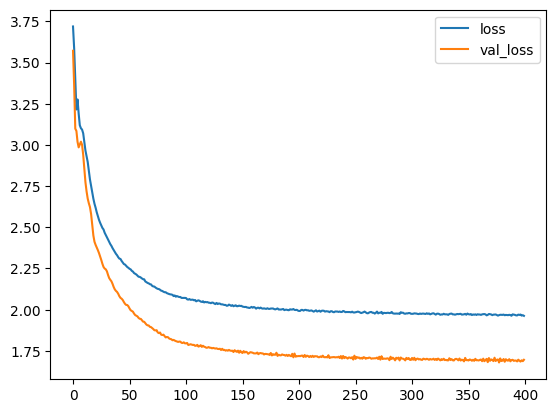

In [13]:
df = pd.DataFrame(results)
df[["loss", "val_loss"]].plot()
plt.legend()
plt.show()

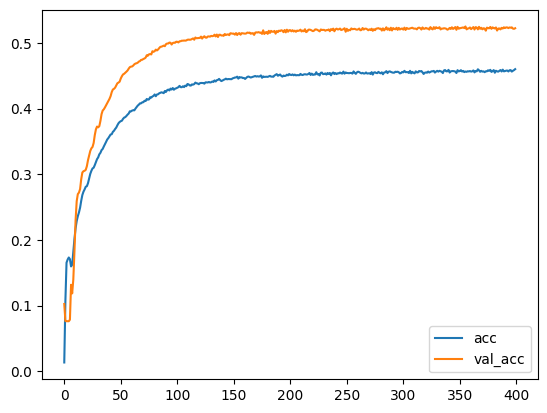

In [14]:
df[["acc", "val_acc"]].plot()
plt.legend()
plt.show()

In [15]:
# test
model.eval()
out = model(dataset)
# loss = F.nll_loss(out[splits["test"]], dataset.y[splits["test"]].flatten())
correct = (out.argmax(-1)[splits["test"]] == dataset.y[splits["test"]].flatten()).sum()
acc = int(correct) / len(splits["test"])

acc

0.5067588420467872

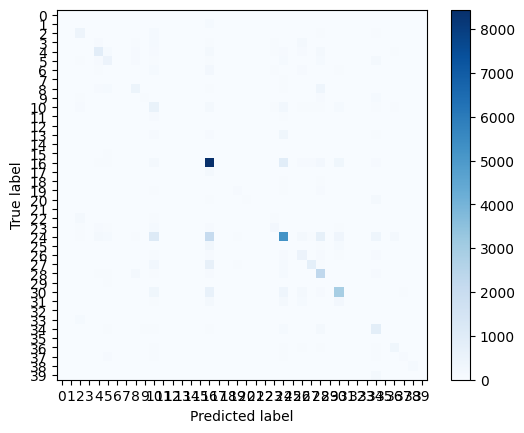

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    dataset.y[splits["test"]].flatten(), out.argmax(-1)[splits["test"]]
)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues", include_values=False)
plt.show()